In [2]:
from lmfit.models import LinearModel, LorentzianModel
import numpy as np
from astropy.io import fits 
import importlib
import sys
sys.path.append('/home/c2032014/py_files')
import load_and_clean as lac
from stingray import Lightcurve, AveragedCrossspectrum
import matplotlib.pyplot as plt
import scipy


In [3]:
data_12,*_=lac.load_and_clean('/home/c2032014/cygx1_paper/cyg_data_all/03010101/event_1pt5/ixpe03010101_det12_event_1pt5_src.fits', 51,200)
data_3,*_=lac.load_and_clean('/home/c2032014/cygx1_paper/cyg_data_all/03010101/event_1pt5/ixpe03010101_det3_evt_1pt5_v01_src.fits', 51,200)

In [4]:
GTI=np.loadtxt('/home/c2032014/cygx1_paper/cyg_data_all/03010101/GTI_ixpe03010101_evt2_v01.txt')

In [5]:
# Lightcurves
lc_12 = Lightcurve.make_lightcurve(data_12['TIME'], dt=1/64, gti=list(GTI))
lc_12.apply_gtis()
lc_3 = Lightcurve.make_lightcurve(data_3['TIME'], dt=1/64, gti=list(GTI))
lc_3.apply_gtis()

In [6]:
cs = AveragedCrossspectrum(lc_12, lc_3, 32)
cs=cs.rebin_log(f=0.1)

/home/c2032014/.local/lib/python3.10/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/home/c2032014/.local/lib/python3.10/site-packages/stingray/fourier.py:1141: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(
/home/c2032014/.local/lib/python3.10/site-packages/stingray/crossspectrum.py:2912: UserWarning: Some error bars in the Averaged Crossspectrum are invalid.Defaulting to sqrt(2 / M) in Leahy norm, rescaled to the appropriate norm.
  warnings.warn(


Best-fit parameters: [6.97056296e-02 1.60370651e-01 1.52338072e-01 8.14709996e-14
 1.39545514e+00 2.58135876e-02]


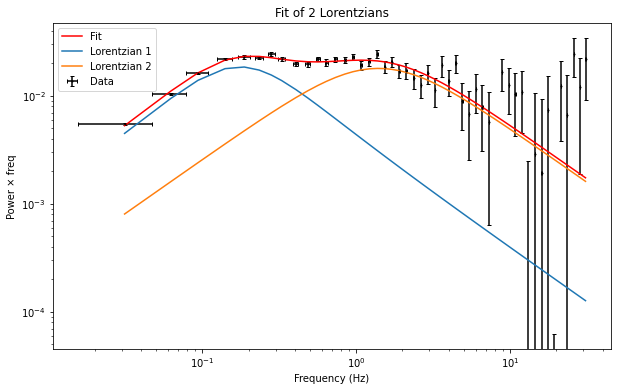

Chi-squared: 74.67778461109268
Degrees of freedom: 43
Reduced chi-squared: 1.7366926653742483


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# General Lorentzian
def lorentzian(x, x0, gamma, A):
    return (A * (gamma**2)) / ((x - x0)**2 + gamma**2)

# General sum of n Lorentzians
def n_lorentzians(x, *params):
    """
    params: [x01, gamma1, A1, x02, gamma2, A2, ..., x0n, gamman, An]
    """
    n = len(params) // 3
    y = np.zeros_like(x)
    for i in range(n):
        xi, gi, Ai = params[3*i:3*(i+1)]
        y += lorentzian(x, xi, gi, Ai)
    return y

# Example: your initial guesses
init_centers = [0.05, 1.18/2]#, 1.18]#, 0.001]  # can be any length
init_fwhm = [0.2, 0.97/2]#, 0.97]#, 5]
init_amplitudes = [0.1, 0.01]#, 0.03]#, 0.05]

# Convert FWHM to gamma
init_gamma = [fw/2 for fw in init_fwhm]

# Flatten initial parameters into p0
p0 = []
for xc, g, A in zip(init_centers, init_gamma, init_amplitudes):
    p0.extend([xc, g, A])

# Example data
xdata = cs.freq
ydata = cs.power.real
yerr = np.array(np.real(cs.power_err))

# Fit
popt, pcov = curve_fit(n_lorentzians, xdata, ydata, p0=p0, sigma=yerr, absolute_sigma=True, maxfev=20000000, bounds=(0, np.inf))

print("Best-fit parameters:", popt)

# Plot results
plt.figure(figsize=(10,6))
plt.errorbar(xdata, ydata*xdata, xerr=cs.df/2, yerr=yerr*xdata, fmt='.', markersize=2, capsize=2, color='black', label="Data")
plt.plot(xdata, n_lorentzians(xdata, *popt)*xdata, 'r-', label="Fit")

# Individual Lorentzians
n = len(popt)//3 
for i in range(n):
    xi, gi, Ai = popt[3*i:3*(i+1)]
    plt.plot(xdata, lorentzian(xdata, xi, gi, Ai)*xdata, '-', label=f"Lorentzian {i+1}")

plt.legend()
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-3, 0.03)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power × freq")
plt.title(f"Fit of {n} Lorentzians")
plt.show()

# Chi-squared
chi_sqr = np.sum(((ydata - n_lorentzians(xdata, *popt)) / yerr)**2)
dof = len(ydata) - len(popt)
print("Chi-squared:", chi_sqr)
print("Degrees of freedom:", dof)
print("Reduced chi-squared:", chi_sqr/dof)


In [8]:
xerr = [cs.df/2]*len(xdata)
yfit = n_lorentzians(xdata, *popt)
comp1 = lorentzian(xdata, *popt[0:3])
comp2 = lorentzian(xdata, *popt[3:6])

In [9]:
data_to_save = np.column_stack([
    xdata,           # Frequency
    ydata,           # Original data
    xerr,
    yerr,
    yfit,       # Total fit
    comp1,
    comp2
])

np.savetxt("lorentzian03010101_plt_data.txt", data_to_save,
           header="freq(Hz) power xerr yerr yfit comp1 comp2")

print("Data saved to lorentzian03010101_plt_data.txt")

Data saved to lorentzian03010101_plt_data.txt
